In [122]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text

In [4]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
df = df[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])].fillna(0).reset_index(drop=True)
df.median_house_value = np.log1p(df.median_house_value)

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [26]:
x_train = df_train.drop(columns = ['median_house_value'])
x_val = df_val.drop(columns = ['median_house_value'])
x_test = df_test.drop(columns = ['median_house_value'])

y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

del df_full_train['median_house_value']

In [29]:
dv = DictVectorizer(sparse=True)
x_train = dv.fit_transform(x_train.to_dict(orient="records"))
x_val = dv.transform(x_val.to_dict(orient="records"))
x_test = dv.transform(x_test.to_dict(orient="records"))

## Question 1

In [70]:
dt = DecisionTreeRegressor(max_depth=1)
model_dt = dt.fit(x_train, y_train)

In [71]:
export_text(model_dt, feature_names=dv.feature_names_).split("\n")

['|--- ocean_proximity=<1H OCEAN <= 0.50',
 '|   |--- value: [11.61]',
 '|--- ocean_proximity=<1H OCEAN >  0.50',
 '|   |--- value: [12.30]',
 '']

- Which feature is used for splitting the data? **ocean_proximity**

## Question 2

In [68]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
model_rf = rf.fit(x_train, y_train)
y_pred = model_rf.predict(x_val)

In [69]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE is {round(rmse, 4)}")

RMSE is 0.245


## Question 3

In [78]:
rmses = []
for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    model_rf = rf.fit(x_train, y_train)
    y_pred = model_rf.predict(x_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmses.append(round(rmse, 3))
    print(f"{n} --> {round(rmse, 3)}")

  0%|          | 0/20 [00:00<?, ?it/s]

10 --> 0.245
20 --> 0.239
30 --> 0.237
40 --> 0.235
50 --> 0.235
60 --> 0.235
70 --> 0.235
80 --> 0.235
90 --> 0.235
100 --> 0.235
110 --> 0.235
120 --> 0.234
130 --> 0.234
140 --> 0.234
150 --> 0.234
160 --> 0.234
170 --> 0.234
180 --> 0.234
190 --> 0.234
200 --> 0.234


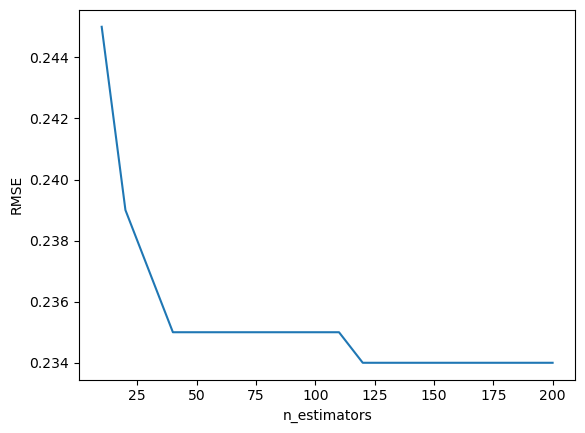

In [79]:
plt.plot(range(10, 201, 10), rmses)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.show()

- After which value of n_estimators does RMSE stop improving? **120**

## Question 4

In [83]:
for d in tqdm([10, 15, 20, 25]):
    rmses = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=d, n_estimators=n, random_state=1, n_jobs=-1)
        model_rf = rf.fit(x_train, y_train)
        y_pred = model_rf.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)
    print(f"{d} --> {round(np.mean(rmses), 3)}")

  0%|          | 0/4 [00:00<?, ?it/s]

10 --> 0.246
15 --> 0.236
20 --> 0.235
25 --> 0.235


- What's the best max_depth, using the mean RMSE? **20 and 25**

## Question 5

In [87]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
model_rf = rf.fit(x_train, y_train)

In [86]:
for feature, importance in zip(dv.feature_names_, model_rf.feature_importances_):
    print(feature, f"---> {round(importance, 4)}")

households ---> 0.0156
housing_median_age ---> 0.0302
latitude ---> 0.1027
longitude ---> 0.0859
median_income ---> 0.3354
ocean_proximity=<1H OCEAN ---> 0.2925
ocean_proximity=INLAND ---> 0.0738
population ---> 0.0272
total_bedrooms ---> 0.0156
total_rooms ---> 0.0211


- What's the most important feature (among these 4)? **median_income**

## Question 6

In [126]:
features = [feat.replace("<","") for feat in dv.feature_names_]
dtrain = xgb.DMatrix(data=x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(data=x_val, label=y_val, feature_names=features)
watchlist = [(dtrain, "train"), (dval, "val")]

In [159]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model_xgb = xgb.train(params= xgb_params, dtrain = dtrain,
                      evals= watchlist, num_boost_round = 100)

In [160]:
lines = output.stdout.split('\n')

history_data = pd.Series(np.array(lines)).str.split('\t')[:-1]
history_03 = pd.DataFrame.from_records(history_data,
                                    columns=('n_iters', 'dtrain_rmse', 'dval_rmse'))
history_03.n_iters = history_03.n_iters.str.strip('[]').astype(int)
transform_auc = lambda col: history_03[col].str.split(':').str[1].astype(float)
history_03.dtrain_rmse = transform_auc('dtrain_rmse')
history_03.dval_rmse = transform_auc('dval_rmse')
history_03.head()

,n_iters,dtrain_rmse,dval_rmse
0,0,0.44350,0.44250
1,1,0.36599,0.36916
2,2,0.31556,0.32382
3,3,0.28541,0.29965
4,4,0.26573,0.28417


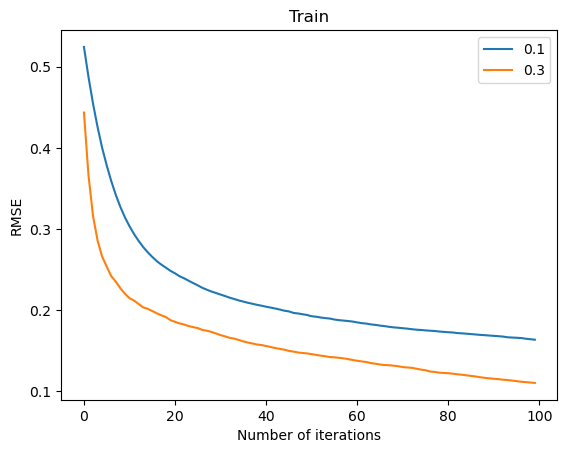

In [161]:
plt.plot(history_01.n_iters, history_01.dtrain_rmse, label="0.1")
plt.plot(history_03.n_iters, history_03.dtrain_rmse, label="0.3")
plt.xlabel("Number of iterations")
plt.ylabel("RMSE")
plt.title("Train")
plt.legend()
plt.show()

In [157]:
lines = output.stdout.split('\n')

history_data = pd.Series(np.array(lines)).str.split('\t')[:-1]
history_01 = pd.DataFrame.from_records(history_data,
                                    columns=('n_iters', 'dtrain_rmse', 'dval_rmse'))
history_01.n_iters = history_01.n_iters.str.strip('[]').astype(int)
transform_auc = lambda col: history_01[col].str.split(':').str[1].astype(float)
history_01.dtrain_rmse = transform_auc('dtrain_rmse')
history_01.dval_rmse = transform_auc('dval_rmse')
history_01.head()

,n_iters,dtrain_rmse,dval_rmse
0,0,0.52449,0.52045
1,1,0.48736,0.48443
2,2,0.45433,0.45293
3,3,0.42533,0.42550
4,4,0.39987,0.40144


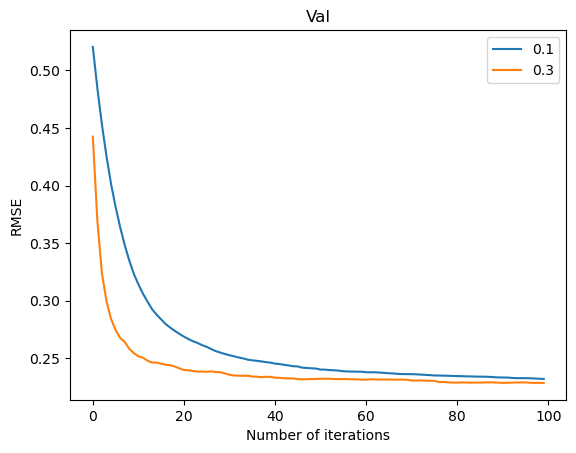

In [162]:
plt.plot(history_01.n_iters, history_01.dval_rmse, label="0.1")
plt.plot(history_03.n_iters, history_03.dval_rmse, label="0.3")
plt.xlabel("Number of iterations")
plt.ylabel("RMSE")
plt.title("Val")
plt.legend()
plt.show()

- Which eta leads to the best RMSE score on the validation dataset? **0.3**